# load and eval model

In [2]:
import argparse
import logging
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append("../..")

In [5]:
feature_path = "/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/new_baseline/processed_data/x-all.pkl"
response_path = "/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/data/features/responses/amg-232_2.5.csv"
output_dir = "nn_test"

In [6]:
logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")

In [7]:
# load data
logger.info("Loading feature data...")
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
feature_df.set_index("ccle_name", inplace=True)
feature_df.fillna(-1, inplace=True)

INFO:__main__:Loading feature data...


In [8]:
logger.info("Loading response data...")
response_df = pd.read_csv(response_path)

# only keep cell lines we have features for
available_ccle_names = set(feature_df.index)
response_df = response_df[response_df["ccle_name"].isin(available_ccle_names)]

# drop culture column
response_df = response_df.drop(columns=["culture"])
# drop duplicates by ccle_name, keep first
response_df = response_df.drop_duplicates(subset=["ccle_name"], keep="first")

INFO:__main__:Loading response data...


In [9]:
from refract.trainers import *
from sklearn.preprocessing import StandardScaler

In [10]:
# train test val split on response_df ccle_names
train_ccle_names, test_ccle_names = train_test_split(response_df["ccle_name"], test_size=0.2, random_state=42)
train_ccle_names, val_ccle_names = train_test_split(train_ccle_names, test_size=0.2, random_state=42)

# get response_train, response_val, response_test dfs in order 
response_train_df = response_df.loc[response_df.ccle_name.isin(train_ccle_names)]
response_val_df = response_df.loc[response_df.ccle_name.isin(val_ccle_names)]
response_test_df = response_df.loc[response_df.ccle_name.isin(test_ccle_names)]

# drop all columns with zero stddev
feature_df = feature_df.loc[:, feature_df.std() != 0]

X_train_df = feature_df.loc[response_train_df.ccle_name.values, :]
X_val_df = feature_df.loc[response_val_df.ccle_name.values, :]
X_test_df = feature_df.loc[response_test_df.ccle_name.values, :]

In [11]:
import glob
import tqdm

In [12]:
response_files = glob.glob("/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/data/features/responses/*.csv")

In [13]:
all_responses = []
for response_path in tqdm.tqdm(response_files):
    response_df = pd.read_csv(response_path)
    df = response_df.loc[:, ["ccle_name", "pert_name", "pert_idose", "LFC.cb"]]
    # concatenate pert_name and pert_idose
    df["pert_name"] = df["pert_name"] + "_" + df["pert_idose"].astype(str)
    df = df.drop(columns=["pert_idose"])
    all_responses.append(df)
response_df = pd.concat(all_responses, axis=0)

100%|██████████| 6513/6513 [00:20<00:00, 310.63it/s]


In [14]:
# now, make a dataset to return the data in expected format
from sklearn.preprocessing import LabelEncoder

class PrismDataset(torch.utils.data.Dataset):
    def __init__(self, feature_df, response_df, drug_name_encoder, \
            cell_line_col="ccle_name", response_col="LFC.cb", drug_col="pert_name"):
        self.feature_df = feature_df
        self.response_df = response_df
        self.cell_line_col = cell_line_col
        self.response_col = response_col
        self.drug_col = drug_col

        self.drug_names = self.response_df[self.drug_col].values
        # encode drug names as integers
        self.drug_name_encoder = drug_name_encoder
        self.drug_names = self.drug_name_encoder.transform(self.drug_names)
        self.cell_lines = self.response_df[self.cell_line_col].values
        self.responses = self.response_df[self.response_col].values
        self.num_embeddings = len(self.drug_name_encoder.classes_)

    def __len__(self):
        return len(self.responses)

    def __getitem__(self, idx):
        response = self.responses[idx]
        drug = self.drug_names[idx]
        cell_line = self.cell_lines[idx]
        features = self.feature_df.loc[cell_line, :].values

        # return all as tensors
        response = torch.tensor(response, dtype=torch.float32)
        drug = torch.tensor(drug, dtype=torch.long)
        features = torch.tensor(features, dtype=torch.float32)

        return features, drug, response

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_model(input_dim, num_embeddings, embedding_dim, dropout_rate=0.5):
    # Define a simple feedforward neural network structure with an embedding layer, dropout, and batch normalization
    class FeedforwardNeuralNetwork(nn.Module):
        def __init__(self, input_dim, num_embeddings, embedding_dim, dropout_rate):
            super(FeedforwardNeuralNetwork, self).__init__()
            # Define an embedding layer for perturbation names
            self.embedding = nn.Embedding(num_embeddings, embedding_dim)
            # Define three hidden layers and output layer
            self.fc1 = nn.Linear(input_dim + embedding_dim, 128)  # First hidden layer, adjusted for embedding
            self.fc2 = nn.Linear(128, 64)                        # Second hidden layer
            self.fc3 = nn.Linear(64, 32)                         # Third hidden layer
            self.fc4 = nn.Linear(32, 1)                          # Output layer
            # Dropout layers
            self.dropout1 = nn.Dropout(dropout_rate)
            self.dropout2 = nn.Dropout(dropout_rate)
            self.dropout3 = nn.Dropout(dropout_rate)
            # Batch normalization layers
            self.bn1 = nn.BatchNorm1d(128)
            self.bn2 = nn.BatchNorm1d(64)
            self.bn3 = nn.BatchNorm1d(32)

        def forward(self, x, pert_name):
            x = x.float()
            # Embedding for the perturbation name
            pert_embedding = self.embedding(pert_name).float()
            # Concatenate the embedding with the input features
            x = torch.cat([x, pert_embedding], dim=1)
            # Activation functions, batch normalization, and dropout for the hidden layers
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = F.relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = F.relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.fc4(x)  # No activation for output layer, assuming regression task
            return x

    # Create the neural network model
    model = FeedforwardNeuralNetwork(input_dim, num_embeddings, embedding_dim, dropout_rate)
    return model


In [16]:
def load_checkpoint(model, optimizer, filename):
    """
    Loads a checkpoint into a PyTorch model and optimizer.

    Args:
        model (torch.nn.Module): The model that you want to load the checkpoint into.
        optimizer (torch.optim.Optimizer): The optimizer for which to load the state dict.
        filename (str): The path to the checkpoint file.

    Returns:
        int: The epoch at which the checkpoint was saved.
        float: The loss at the checkpoint.
    """
    # Load the saved checkpoint
    checkpoint = torch.load(filename)

    # Restore the model and optimizer state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Restore other information
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss


In [17]:
# only keep responses we have features for
response_df = response_df[response_df["ccle_name"].isin(available_ccle_names)]

In [18]:
# split the responses by train, val, test on ccle_name
response_train = response_df[response_df["ccle_name"].isin(train_ccle_names)]
response_val = response_df[response_df["ccle_name"].isin(val_ccle_names)]
response_test = response_df[response_df["ccle_name"].isin(test_ccle_names)]

# filter X_train, X_val, X_test to only top features
#X_train = X_train_df.loc[:, top_features]
#X_val = X_val_df.loc[:, top_features]
#X_test = X_test_df.loc[:, top_features]

X_train = X_train_df.copy()
X_val = X_val_df.copy()
X_test = X_test_df.copy()


In [19]:
# standard scale the features, return dataframes
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [20]:
from sklearn.preprocessing import LabelEncoder
drug_encoder = LabelEncoder()
drugs = response_df.pert_name.unique()
drug_encoder = drug_encoder.fit(drugs)

In [21]:
# create the datasets
train_dataset = PrismDataset(X_train, response_train, drug_encoder)
val_dataset = PrismDataset(X_val, response_val, drug_encoder)
test_dataset = PrismDataset(X_test, response_test, drug_encoder)

In [22]:
# get the model 
model = get_model(input_dim=X_train.shape[1], num_embeddings=train_dataset.num_embeddings, embedding_dim=10)

In [24]:
# load the model state
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
checkpoint_path = "model_checkpoint_19.pth"
load_checkpoint(model, optimizer, checkpoint_path)

(19, tensor(0.1733, device='cuda:0'))

In [27]:
model.eval()

FeedforwardNeuralNetwork(
  (embedding): Embedding(6513, 10)
  (fc1): Linear(in_features=110145, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [38]:
# get predictions on train
train_predictions = []
train_labels = []

for i in tqdm.tqdm(range(len(test_dataset))):
    features, drug, response = test_dataset[i]
    features = features.unsqueeze(0)
    drug = drug.unsqueeze(0)
    response = response.unsqueeze(0)
    prediction = model(features, drug)
    train_predictions.append(prediction.detach().numpy())
    train_labels.append(response.detach().numpy())

  1%|          | 4315/753472 [00:15<44:26, 280.92it/s]  


KeyboardInterrupt: 

In [39]:
import matplotlib.pyplot as plt

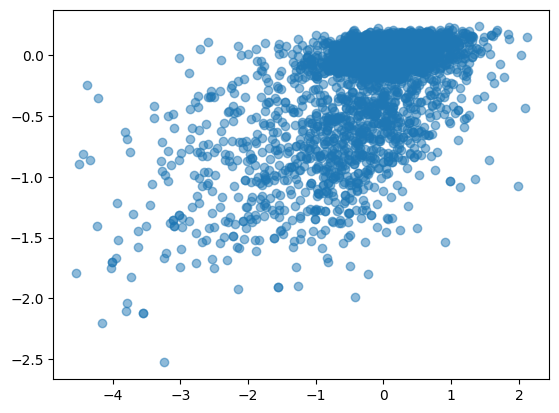

In [40]:
plt.scatter(train_labels, train_predictions, alpha=0.5)

In [41]:
# whats the pearson score
from scipy.stats import pearsonr
pearson_score = pearsonr(np.array(train_labels).flatten(), np.array(train_predictions).flatten())
print(f"Pearson score on train: {pearson_score}")

Pearson score on train: PearsonRResult(statistic=0.5975996804658364, pvalue=0.0)


# Fine tune this on a smaller dataset

In [59]:
tmp_df = response_df.loc[response_df.pert_name == "amg-232_2.5", :]

In [60]:
# split the responses by train, val, test on ccle_name
response_train = tmp_df[tmp_df["ccle_name"].isin(train_ccle_names)]
response_val = tmp_df[tmp_df["ccle_name"].isin(val_ccle_names)]
response_test = tmp_df[tmp_df["ccle_name"].isin(test_ccle_names)]

# filter X_train, X_val, X_test to only top features
#X_train = X_train_df.loc[:, top_features]
#X_val = X_val_df.loc[:, top_features]
#X_test = X_test_df.loc[:, top_features]

X_train = X_train_df.copy()
X_val = X_val_df.copy()
X_test = X_test_df.copy()


In [61]:
# standard scale the features, return dataframes
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [62]:
# create the datasets
train_dataset = PrismDataset(X_train, response_train, drug_encoder)
val_dataset = PrismDataset(X_val, response_val, drug_encoder)
test_dataset = PrismDataset(X_test, response_test, drug_encoder)

In [64]:
# Create dataloaders for training and test
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=24)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=24)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=24)

In [65]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

def save_checkpoint(model, optimizer, epoch, loss, filename="finetune_model_checkpoint_{}.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename.format(epoch))

def train_model(model, train_dataloader, val_dataloader, num_epochs, patience):
    # Assuming the loss function and optimizer are predefined globally or are parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    # Initialize TensorBoard writer
    writer = SummaryWriter()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for inputs, cell_line, targets in tqdm.tqdm(train_dataloader):
            inputs, cell_line, targets = inputs.to(device), cell_line.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs, cell_line).squeeze().float()
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataloader.dataset)

        # Log training loss
        writer.add_scalar('Loss/Train', train_loss, epoch)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for inputs, cell_line, targets in val_dataloader:
                inputs, cell_line, targets = inputs.to(device), cell_line.to(device), targets.to(device)
                outputs = model(inputs, cell_line).squeeze().float()
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)

        # Log validation loss
        writer.add_scalar('Loss/Validation', val_loss, epoch)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        save_checkpoint(model, optimizer, epoch, loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Close the writer
    writer.close()

    # Load the best model back
    model.load_state_dict(torch.load('best_model.pth'))

# Example call to the training function:
# train_model(model, train_loader, val_loader, num_epochs=50, patience=5)


In [66]:
layers_to_freeze = ["embedding", "fc1", "fc2"]

In [67]:
def freeze_layers(model, layers_to_freeze):
    """
    Freezes the specified layers of the model.

    Args:
        model (torch.nn.Module): The model whose layers are to be frozen.
        layers_to_freeze (list of str): Names of the layers to freeze.
    """
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_freeze):
            param.requires_grad = False


In [68]:
freeze_layers(model, layers_to_freeze)

In [69]:
model

FeedforwardNeuralNetwork(
  (embedding): Embedding(6513, 10)
  (fc1): Linear(in_features=110145, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [70]:
train_model(model, train_dl, val_dl, num_epochs=200, patience=10)

100%|██████████| 23/23 [00:01<00:00, 12.21it/s]


Epoch [1/200], Train Loss: 2.4992, Val Loss: 2.8646


100%|██████████| 23/23 [00:02<00:00,  9.79it/s]


Epoch [2/200], Train Loss: 2.3106, Val Loss: 2.8206


100%|██████████| 23/23 [00:01<00:00, 11.92it/s]


Epoch [3/200], Train Loss: 2.0704, Val Loss: 2.7161


100%|██████████| 23/23 [00:02<00:00, 10.44it/s]


Epoch [4/200], Train Loss: 2.0106, Val Loss: 2.5926


100%|██████████| 23/23 [00:01<00:00, 12.10it/s]


Epoch [5/200], Train Loss: 2.0036, Val Loss: 2.4346


100%|██████████| 23/23 [00:02<00:00, 10.83it/s]


Epoch [6/200], Train Loss: 1.8261, Val Loss: 2.3082


100%|██████████| 23/23 [00:01<00:00, 11.56it/s]


Epoch [7/200], Train Loss: 1.7533, Val Loss: 2.1874


100%|██████████| 23/23 [00:01<00:00, 12.01it/s]


Epoch [8/200], Train Loss: 1.7107, Val Loss: 2.1875


100%|██████████| 23/23 [00:02<00:00, 10.35it/s]


Epoch [9/200], Train Loss: 1.5564, Val Loss: 2.1244


100%|██████████| 23/23 [00:01<00:00, 11.78it/s]


Epoch [10/200], Train Loss: 1.6460, Val Loss: 1.9593


100%|██████████| 23/23 [00:01<00:00, 11.97it/s]


Epoch [11/200], Train Loss: 1.6359, Val Loss: 1.9724


100%|██████████| 23/23 [00:01<00:00, 11.95it/s]


Epoch [12/200], Train Loss: 1.4778, Val Loss: 1.9394


100%|██████████| 23/23 [00:01<00:00, 12.14it/s]


Epoch [13/200], Train Loss: 1.5623, Val Loss: 1.8814


100%|██████████| 23/23 [00:02<00:00,  9.35it/s]


Epoch [14/200], Train Loss: 1.6177, Val Loss: 1.8531


100%|██████████| 23/23 [00:01<00:00, 12.05it/s]


Epoch [15/200], Train Loss: 1.4702, Val Loss: 1.8391


100%|██████████| 23/23 [00:01<00:00, 12.09it/s]


Epoch [16/200], Train Loss: 1.5405, Val Loss: 1.7846


100%|██████████| 23/23 [00:01<00:00, 11.93it/s]


Epoch [17/200], Train Loss: 1.4044, Val Loss: 1.8041


100%|██████████| 23/23 [00:01<00:00, 12.01it/s]


Epoch [18/200], Train Loss: 1.5040, Val Loss: 1.7325


100%|██████████| 23/23 [00:01<00:00, 11.92it/s]


Epoch [19/200], Train Loss: 1.3869, Val Loss: 1.7776


100%|██████████| 23/23 [00:01<00:00, 11.76it/s]


Epoch [20/200], Train Loss: 1.4268, Val Loss: 1.7671


100%|██████████| 23/23 [00:02<00:00, 11.30it/s]


Epoch [21/200], Train Loss: 1.4865, Val Loss: 1.7403


100%|██████████| 23/23 [00:02<00:00, 10.54it/s]


Epoch [22/200], Train Loss: 1.5091, Val Loss: 1.7267


100%|██████████| 23/23 [00:01<00:00, 11.74it/s]


Epoch [23/200], Train Loss: 1.4470, Val Loss: 1.7573


100%|██████████| 23/23 [00:01<00:00, 11.80it/s]


Epoch [24/200], Train Loss: 1.4069, Val Loss: 1.8315


100%|██████████| 23/23 [00:01<00:00, 11.79it/s]


Epoch [25/200], Train Loss: 1.5111, Val Loss: 1.7584


100%|██████████| 23/23 [00:01<00:00, 11.96it/s]


Epoch [26/200], Train Loss: 1.5239, Val Loss: 1.7049


100%|██████████| 23/23 [00:01<00:00, 12.03it/s]


Epoch [27/200], Train Loss: 1.3789, Val Loss: 1.7574


100%|██████████| 23/23 [00:01<00:00, 11.77it/s]


Epoch [28/200], Train Loss: 1.3428, Val Loss: 1.7248


100%|██████████| 23/23 [00:01<00:00, 12.07it/s]


Epoch [29/200], Train Loss: 1.4420, Val Loss: 1.7372


100%|██████████| 23/23 [00:01<00:00, 11.53it/s]


Epoch [30/200], Train Loss: 1.3971, Val Loss: 1.7233


100%|██████████| 23/23 [00:02<00:00, 10.92it/s]


Epoch [31/200], Train Loss: 1.4293, Val Loss: 1.7263


100%|██████████| 23/23 [00:01<00:00, 11.69it/s]


Epoch [32/200], Train Loss: 1.4280, Val Loss: 1.7437


100%|██████████| 23/23 [00:01<00:00, 11.73it/s]


Epoch [33/200], Train Loss: 1.3849, Val Loss: 1.7546


100%|██████████| 23/23 [00:01<00:00, 11.68it/s]


Epoch [34/200], Train Loss: 1.3811, Val Loss: 1.7141


100%|██████████| 23/23 [00:01<00:00, 11.65it/s]


Epoch [35/200], Train Loss: 1.4263, Val Loss: 1.6761


100%|██████████| 23/23 [00:01<00:00, 11.96it/s]


Epoch [36/200], Train Loss: 1.4362, Val Loss: 1.6871


100%|██████████| 23/23 [00:01<00:00, 11.82it/s]


Epoch [37/200], Train Loss: 1.3947, Val Loss: 1.7037


100%|██████████| 23/23 [00:01<00:00, 11.75it/s]


Epoch [38/200], Train Loss: 1.4908, Val Loss: 1.6868


100%|██████████| 23/23 [00:01<00:00, 11.50it/s]


Epoch [39/200], Train Loss: 1.4464, Val Loss: 1.7090


100%|██████████| 23/23 [00:02<00:00, 10.41it/s]


Epoch [40/200], Train Loss: 1.5124, Val Loss: 1.6881


100%|██████████| 23/23 [00:02<00:00, 11.31it/s]


Epoch [41/200], Train Loss: 1.3772, Val Loss: 1.7199


100%|██████████| 23/23 [00:02<00:00, 11.09it/s]


Epoch [42/200], Train Loss: 1.4131, Val Loss: 1.7170


100%|██████████| 23/23 [00:02<00:00, 10.74it/s]


Epoch [43/200], Train Loss: 1.4307, Val Loss: 1.7042


100%|██████████| 23/23 [00:02<00:00,  9.59it/s]


Epoch [44/200], Train Loss: 1.2990, Val Loss: 1.7122


100%|██████████| 23/23 [00:01<00:00, 11.86it/s]


Epoch [45/200], Train Loss: 1.3819, Val Loss: 1.6980
Early stopping triggered


In [72]:
model.eval()

FeedforwardNeuralNetwork(
  (embedding): Embedding(6513, 10)
  (fc1): Linear(in_features=110145, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [74]:
model.to("cpu")

FeedforwardNeuralNetwork(
  (embedding): Embedding(6513, 10)
  (fc1): Linear(in_features=110145, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [75]:
# get the preds
test_predictions = []
test_labels = []

for i in tqdm.tqdm(range(len(test_dataset))):
    features, drug, response = test_dataset[i]
    features = features.unsqueeze(0)
    drug = drug.unsqueeze(0)
    response = response.unsqueeze(0)
    prediction = model(features, drug)
    test_predictions.append(prediction.detach().numpy())
    test_labels.append(response.detach().numpy())

100%|██████████| 117/117 [00:00<00:00, 307.06it/s]


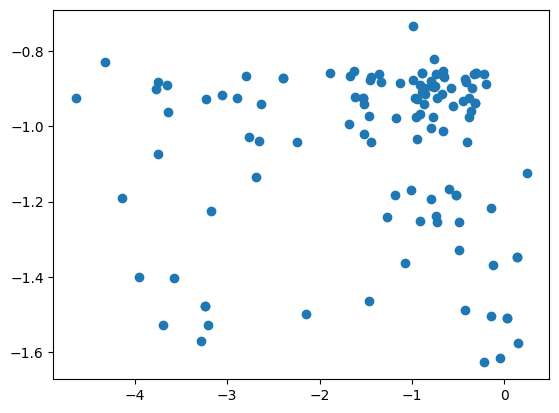

In [76]:
plt.scatter(test_labels, test_predictions)

In [78]:
# get number of parameters in model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

481